In [101]:
import pandas as pd
import numpy as np
import networkx as nx
import graph as gr
import utils as ut
import feature_selection as fs
import classification as cl
import os.path
import matplotlib.pyplot as plt
from sklearn import preprocessing
import importlib
import community
import seaborn as sns
importlib.reload(ut)

<module 'utils' from 'C:\\Users\\faisal\\PycharmProjects\\linkPrediction\\utils.py'>

In [255]:
from gensim.models import KeyedVectors
from pyemd import emd
from gensim import corpora
from nltk.corpus import stopwords
from gensim.matutils import softcossim

In [254]:
word_vectors = KeyedVectors.load_word2vec_format('pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin', binary=True)

In [2]:
filepath=['dataset/apnea-all,3.csv',
         'dataset/apnea-distinct_keyword.csv']
graphpath='C:/Users/faisal/PycharmProjects/linkPrediction/graphs'
df, key_list = ut.load_dataset(filepath)

In [3]:
nodes={}
ts=1993
te=2003
it_index=1

#dynamic graph build and save
#nodes intersection between train and test
nodes=gr.nodes_intersection(df, key_list, ts, te, te+2)
print(len(nodes))
#dynamic train graph build
for t in range(ts,te,it_index):
    g=nx.Graph()
    train_graph = gr.build_graph(g, df, key_list, nodes, t, t+1)
    file="train_graph_"+str(t)
    file_name = os.path.join(graphpath, file+".gpickle")
    gr.save_graph(train_graph, file_name)
    print(file_name+" saved,","nodes:",len(train_graph.nodes()),"edges:",len(train_graph.edges()))

#test graph build and save
g=nx.Graph()
test_graph = gr.build_graph(g, df, key_list, nodes, te, te+2)
file="test_graph_"+str(te)+"-"+str(te+2)
file_name = os.path.join(graphpath, file+".gpickle")
gr.save_graph(test_graph, file_name)
print(file_name+" saved,","nodes:",len(test_graph.nodes()),"edges:",len(test_graph.edges()))

665
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle saved, nodes: 102 edges: 135
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle saved, nodes: 123 edges: 107
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle saved, nodes: 181 edges: 253
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle saved, nodes: 200 edges: 287
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle saved, nodes: 190 edges: 219
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle saved, nodes: 200 edges: 269
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle saved, nodes: 218 edges: 234
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000.gpickle saved, nodes: 255 edges: 409
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2001.gpickle saved, nodes: 281 edges: 446
C:/Users/faisal/PycharmP

In [4]:
#static graph build and save
ts=1980
te=1993
#parent graph buile and save
g=nx.Graph()
parent_graph = gr.build_graph(g, df, key_list, nodes, ts, te)
file="parent_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
gr.save_graph(parent_graph, file_name)
print(file_name+" saved,","nodes:",len(parent_graph.nodes()),"edges:",len(parent_graph.edges()))
#static train graph buile and save
ts=1993
te=2003
g=nx.Graph()
train_graph_static = gr.build_graph(g, df, key_list, nodes, ts, te)
file="train_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
gr.save_graph(train_graph_static, file_name)
print(file_name+" saved,","nodes:",len(train_graph_static.nodes()),"edges:",len(train_graph_static.edges()))

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\parent_graph_1980-1993.gpickle saved, nodes: 199 edges: 292
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993-2003.gpickle saved, nodes: 665 edges: 2171


In [5]:
#load graph
#dynamic train graph
g_train={}
ts=1993
te=2003
it_index=1
for t in range(ts,te,it_index):
    file="train_graph_"+str(t)
    file_name = os.path.join(graphpath, file+".gpickle")
    g_train[t]=gr.load_graph(file_name)
    print(file_name+" loaded,","nodes:",len(g_train[t].nodes()),"edges:",len(g_train[t].edges()))
#test graph
file="test_graph_"+str(te)+"-"+str(te+2)
file_name = os.path.join(graphpath, file+".gpickle")
g_test=gr.load_graph(file_name)
print(file_name+" loaded,","nodes:",len(g_test.nodes()),"edges:",len(g_test.edges()))
#parent graph
ts=1980
te=1993
file="parent_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
g_parent=gr.load_graph(file_name)
print(file_name+" loaded,","nodes:",len(g_parent.nodes()),"edges:",len(g_parent.edges()))
#static train graph
ts=1993
te=2003
file="train_graph_"+str(ts)+"-"+str(te)
file_name = os.path.join(graphpath, file+".gpickle")
g_train_static=gr.load_graph(file_name)
print(file_name+" loaded,","nodes:",len(g_train_static.nodes()),"edges:",len(g_train_static.edges()))

C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1993.gpickle loaded, nodes: 102 edges: 135
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1994.gpickle loaded, nodes: 123 edges: 107
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1995.gpickle loaded, nodes: 181 edges: 253
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1996.gpickle loaded, nodes: 200 edges: 287
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1997.gpickle loaded, nodes: 190 edges: 219
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1998.gpickle loaded, nodes: 200 edges: 269
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_1999.gpickle loaded, nodes: 218 edges: 234
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2000.gpickle loaded, nodes: 255 edges: 409
C:/Users/faisal/PycharmProjects/linkPrediction/graphs\train_graph_2001.gpickle loaded, nodes: 281 edges: 446
C:/Users/faisal/Pyc

In [36]:
#build dataset for feature
train_data={}
ts=1993
te=2003
it_index=1
freq=5
for t in range(ts,te,it_index):
    train_data[t] = cl.classification_train_data(g_train[t],g_test)
    cl.print_attributes(train_data[t],'train')
    train_data[t] = ut.shuffling(train_data[t],freq)
    cl.print_attributes(train_data[t],'train')
test_data = cl.classification_test_data(g_test)
cl.print_attributes(test_data,'test')

positive train: 120 negative train: 4896 train_size: 5016
positive train: 120 negative train: 600 train_size: 720
positive train: 162 negative train: 7234 train_size: 7396
positive train: 162 negative train: 810 train_size: 972
positive train: 249 negative train: 15788 train_size: 16037
positive train: 249 negative train: 1245 train_size: 1494
positive train: 310 negative train: 19303 train_size: 19613
positive train: 310 negative train: 1550 train_size: 1860
positive train: 287 negative train: 17449 train_size: 17736
positive train: 287 negative train: 1435 train_size: 1722
positive train: 319 negative train: 19312 train_size: 19631
positive train: 319 negative train: 1595 train_size: 1914
positive train: 346 negative train: 23073 train_size: 23419
positive train: 346 negative train: 1730 train_size: 2076
positive train: 359 negative train: 31617 train_size: 31976
positive train: 359 negative train: 1795 train_size: 2154
positive train: 394 negative train: 38500 train_size: 38894
posi

In [7]:
#build parent and static train dataset
parent_data = cl.classification_train_data(g_parent,g_test)
cl.print_attributes(parent_data,'train')
train_data_static = cl.classification_train_data(g_train_static,g_test)
cl.print_attributes(train_data_static,'train')
#parent node feature
parent_node_feature = fs.build_feature_set(df, key_list, g_parent, ts, te)
#train node feature
train_node_feature_static = fs.build_feature_set(df, key_list, g_train_static, 1993, 2003)

positive train: 286 negative train: 19123 train_size: 19409
positive train: 820 negative train: 217789 train_size: 218609
1026
6440


3.812695014170929 6.129084679815224


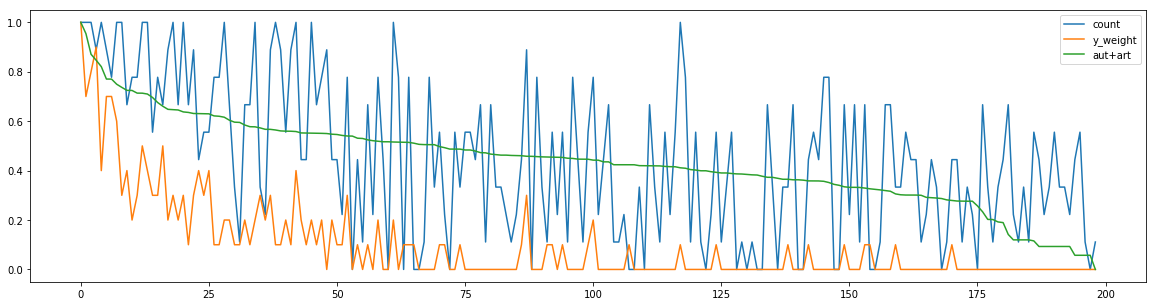

In [8]:
parent_node_feature['aut+art'] = parent_node_feature.apply(lambda row: 0.7*row['term_art']+row['term_aut'], axis=1)
ts=1993
te=2003
it_index=1
parent_node_feature['count']=0
c=[]
for t in range(ts,te,it_index):
    parent_node_feature['count'] = parent_node_feature.apply(lambda row: row['count']+1
                                                            if row['node_index'] in set(g_train[t].nodes()) 
                                                             else row['count'], axis=1)
parent_node_feature['aut+art']=ut.min_max_norm(parent_node_feature['aut+art'])
parent_node_feature['count']=ut.min_max_norm(parent_node_feature['count'])
parent_node_feature['y_weight']=ut.min_max_norm(parent_node_feature['y_weight'])

a = np.linalg.norm(parent_node_feature['aut+art']-parent_node_feature['count'])
b = np.linalg.norm(parent_node_feature['y_weight']-parent_node_feature['count'])
print(a,b)

parent_1st = parent_node_feature.sort_values('aut+art', ascending=False)
parent_1st = parent_1st[0:200]
parent_1st = parent_1st.reset_index()
parent_1st.plot(y=["count","y_weight", "aut+art"],figsize=(20, 5))

In [147]:
#title analysis
for i,j in train_data[1991].iterrows():
    node1=gr.node_label_find(key_list,j[0][0])
    node2=gr.node_label_find(key_list,j[0][1])
#     if (j[1]==0):
#         print(node1,'+',node2,"------------------")
#         print(g_train[1991].nodes[j[0][0]]['title'])
#         print('--------------------')
#         print(g_train[1991].nodes[j[0][1]]['title'])
#         print('\n')

In [37]:
ts=1993
te=2003
it_index=1
partition = {}
d_c={}
for t in range(ts,te,it_index):
    partition[t] = community.best_partition(g_train[t])
    G_main_com = g_train[t].copy()
    d_c[t]={}
    for com in set(partition[t].values()) :
        list_nodes = [node for node in partition[t].keys() if partition[t][node] == com]
        H = G_main_com.subgraph(list_nodes)
        d_c[t][com] = nx.degree_centrality(H)

In [38]:
ts=1993
te=2003
it_index=1
parent_1st_total = set(parent_1st['node_index'])
parent_1st_set = set(parent_1st['node_index'][0:10])
parent_2nd =set()
p_len=[]

p1={}
p2={}
ch={}
gst={}
p1[1993]=parent_1st_set.intersection(set(g_train[1993].nodes()))
p2[1993]=set()
ch[1993]=set()
gst[1993]=set()
for t in range(ts,te,it_index):
    for p in p1[t]:
        nb1 = set(nx.all_neighbors(g_train[t],p))
        p2[t].update(nb1)
        for nbs in nb1:
            nb2 = set(nx.all_neighbors(g_train[t],nbs))
            ch[t].update(nb2)
    p2[t]=p2[t].difference(p1[t])
    ch[t]=ch[t].difference(p1[t],p2[t])
    gst[t]=set(g_train[t].nodes()).difference(p1[t],p2[t],ch[t])
    if t<te-1:
        p1[t+1]=p1[t].union(p2[t])
        p1[t+1]=p1[t+1].intersection(set(g_train[t+1].nodes()))
        p2[t+1]=set()
        ch[t+1]=set()
        gst[t+1]=set()        
    print(len(p1[t]),len(p2[t]),len(ch[t]),len(gst[t]),t)    

p1p=[]
p2p=[]
chp=[]
gstp=[]
p1n=[]
p2n=[]
chn=[]
gstn=[]
p1p2p=[]
p1p2n=[]
p1gstp=[]
p1gstn=[]
for t in range(ts,te,it_index):
    p1p.append(0)
    p2p.append(0)
    chp.append(0)
    gstp.append(0)
    p1n.append(0)
    p2n.append(0)
    chn.append(0)
    gstn.append(0)
    p1p2p.append(0)
    p1p2n.append(0)
    p1gstp.append(0)
    p1gstn.append(0)
    index = t-ts
    for i,rows in train_data[t].iterrows():
        if ((rows[0][0] in p1[t]) and (rows[0][1] in p1[t])) and rows['label']==1:
            p1p[index]=p1p[index]+1
        if ((rows[0][0] in p1[t]) and (rows[0][1] in p1[t])) and rows['label']==0:
            p1n[index]=p1n[index]+1
        if ((rows[0][0] in p2[t]) and (rows[0][1] in p2[t])) and rows['label']==1:
            p2p[index]=p2p[index]+1
        if ((rows[0][0] in p2[t]) and (rows[0][1] in p2[t])) and rows['label']==0:
            p2n[index]=p2n[index]+1
        if ((rows[0][0] in ch[t]) and (rows[0][1] in ch[t])) and rows['label']==1:
            chp[index]=chp[index]+1
        if ((rows[0][0] in ch[t]) and (rows[0][1] in ch[t])) and rows['label']==0:
            chn[index]=chn[index]+1
        if ((rows[0][0] in gst[t]) and (rows[0][1] in gst[t])) and rows['label']==1:
            gstp[index]=gstp[index]+1
        if ((rows[0][0] in gst[t]) and (rows[0][1] in gst[t])) and rows['label']==0:
            gstn[index]=gstn[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in p2[t])) or
            ((rows[0][0] in p2[t]) and (rows[0][1] in p1[t]))) and rows['label']==1:
            p1p2p[index]=p1p2p[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in p2[t])) or
            ((rows[0][0] in p2[t]) and (rows[0][1] in p1[t]))) and rows['label']==0:
            p1p2n[index]=p1p2n[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in gst[t])) or
            ((rows[0][0] in gst[t]) and (rows[0][1] in p1[t]))) and rows['label']==1:
            p1gstp[index]=p1gstp[index]+1
        if (((rows[0][0] in p1[t]) and (rows[0][1] in gst[t])) or
            ((rows[0][0] in gst[t]) and (rows[0][1] in p1[t]))) and rows['label']==0:
            p1gstn[index]=p1gstn[index]+1
    cl.print_attributes(train_data[t],'train')
    print("p1p:",p1p[index],"p1n:",p1n[index],"p2p:",p2p[index],"p2n:",
          p2n[index],"chp:",chp[index],"chn:",chn[index],"gstp:",
          gstp[index],"gstn:",gstn[index],t,"p1p2p:",
          p1p2p[index],"p1p2n:",p1p2n[index],"p1gstp:",p1gstp[index],"p1gstn:",p1gstn[index],
          p1p[index]+p2p[index]+p1p2p[index]+p1gstp[index]+chp[index],
          p1n[index]+p2n[index]+p1p2n[index]+p1gstn[index]+chn[index])
    #print(p1p[index],p1n[index])
    
        


8 21 18 55 1993
16 41 3 63 1994
36 67 12 66 1995
65 74 5 56 1996
85 52 7 46 1997
75 72 5 48 1998
84 71 12 51 1999
88 94 6 67 2000
107 105 7 62 2001
126 111 9 65 2002
positive train: 120 negative train: 600 train_size: 720
p1p: 7 p1n: 3 p2p: 0 p2n: 25 chp: 7 chn: 12 gstp: 22 gstn: 183 1993 p1p2p: 10 p1p2n: 12 p1gstp: 35 p1gstn: 54 59 106
positive train: 162 negative train: 810 train_size: 972
p1p: 10 p1n: 11 p2p: 15 p2n: 91 chp: 0 chn: 2 gstp: 21 gstn: 190 1994 p1p2p: 32 p1p2n: 62 p1gstp: 41 p1gstn: 127 98 293
positive train: 249 negative train: 1245 train_size: 1494
p1p: 40 p1n: 43 p2p: 31 p2n: 164 chp: 0 chn: 4 gstp: 16 gstn: 178 1995 p1p2p: 53 p1p2n: 172 p1gstp: 49 p1gstn: 195 173 578
positive train: 310 negative train: 1550 train_size: 1860
p1p: 94 p1n: 158 p2p: 17 p2n: 198 chp: 0 chn: 1 gstp: 7 gstn: 123 1996 p1p2p: 81 p1p2n: 364 p1gstp: 71 p1gstn: 293 263 1014
positive train: 287 negative train: 1435 train_size: 1722
p1p: 129 p1n: 274 p2p: 7 p2n: 103 chp: 0 chn: 3 gstp: 8 gstn: 78

In [256]:
ts=1993
te=2003
it_index=1
list1 = []
for t in range(ts,te,it_index):
    counn=0
    counp=0
    weight={}
    for i,rows in train_data[t].iterrows():
        n1=rows[0][0]
        n2=rows[0][1]
        l1=gr.node_label_find(key_list,n1)
        l2=gr.node_label_find(key_list,n2)
        #l=list( nx.all_simple_paths(g_train[t], source=rows[0][0], target=rows[0][1],cutoff=3))
#         nb1 = set(nx.all_neighbors(g_train[t],rows[0][0]))
#         nb2 = set(nx.all_neighbors(g_train[t],rows[0][1]))
        if rows['label']==1:
            print(l1,"-",l2,"+++++++++++++++")
            print(word_vectors.n_similarity(l1.lower().split(), l2.lower().split()))
#             print(g_train[t].nodes[n1]['title'])
#             print(g_train[t].nodes[n2]['title'])
        if rows['label']==0:
            print(l1,"-",l2,"----------------")
            print(word_vectors.n_similarity(l1.lower().split(), l2.lower().split()))
#             print(g_train[t].nodes[n1]['title'])
#             print(g_train[t].nodes[n2]['title'])
#             counn=counn+1
    print(counp,counn)

sleep fragmentation - larynx ----------------
0.09306789596624684
narcolepsy - hemodynamics ----------------
0.15051164155645438
hypertension - depression +++++++++++++++
0.474122664773128
airway - pharynx ----------------
0.486440728557152
alcohol - ventilatory control ----------------
0.24601616806088084
pharyngeal pressure - therapy ----------------
0.24946210199924954
high altitude - body position ----------------
0.3421392236454759
sleepiness - oropharynx ----------------
0.14277379806859616
ondine curse - chemoreceptors ----------------
0.18180823520033107
pressure support - alte ----------------
0.1743892184583323
fibromyalgia - cephalometric ----------------
0.21293008565498642
child - insomnia ----------------
0.341248807496575
weight loss - upper airway mechanics ----------------
0.34245849938949563
review - pharynx ----------------
0.1408935289085189
review - cephalometric ----------------
0.17112680134773658
pharynx - co2 response ----------------
0.1708022135917528
compute

upper airway muscle - fibromyalgia ----------------
0.22114810298426033
reflux - respiratory control ----------------
0.34858934397372876
congenital central hypoventilation - upper ----------------
0.403158514125809
review - sudden infant death syndrome ----------------
0.32533155544749287
computed tomography - upper ----------------
0.31195035519664516
tonsillectomy - insulin resistance ----------------
0.13240142029314206
co2 response - aging ----------------
0.27287246879016874
airway - sleep +++++++++++++++
0.3139671296384618
oxygen saturation - sleep ----------------
0.34138282975094425
weight loss - alte ----------------
0.17635077601482704
brainstem - syndrome ----------------
0.28198119413852474
ondine curse - hyperventilation ----------------
0.3598855273848178
hypoventilation - proteinuria ----------------
0.25768136756550025
hypercapnia - heart rate +++++++++++++++
0.3162505722255562
tracheostomy - anesthesia ----------------
0.4960743161449344
hemodynamics - congenital cent

pharyngeal pressure - ventilation ----------------
0.5008261137308274
hemodynamics - hyperventilation ----------------
0.4217895180655611
sleep fragmentation - insomnia +++++++++++++++
0.6013435685667992
hypoxic ventilatory response - aging ----------------
0.284861175992553
sudden infant death syndrome - hyperventilation ----------------
0.3740438685826562
ambulatory - sleep +++++++++++++++
0.4533097851946142
genioglossus - respiration +++++++++++++++
0.4037814103175271
narcolepsy - insomnia +++++++++++++++
0.6308057096799815
pharyngeal pressure - biological rhythm ----------------
0.31902273000409215
zolpidem - oropharynx ----------------
0.1579127684815867
chemoreceptors - upper airway ----------------
0.3168835172993405
depression - insomnia +++++++++++++++
0.7363812853838158
pressure support - sleep fragmentation ----------------
0.3553978939104756
oropharynx - snoring ----------------
0.3740238403878496
review - mechanical ventilation ----------------
0.17801346663022438
nasal ob

cephalometric - snoring +++++++++++++++
0.4884930636116446
sudden infant death syndrome - sleep +++++++++++++++
0.37357294106506717
child - mechanical ventilation ----------------
0.19083823275901754
ambulatory - flow limitation ----------------
0.25649018859119727
computed tomography - testosterone ----------------
0.0641743002019161
hypoventilation - depression ----------------
0.36365819268308575
computed tomography - alte ----------------
0.16234400599178617
carbon dioxide - upper airway muscle +++++++++++++++
0.3138658163047563
hypoxemia - snoring ----------------
0.5128073262824542
flow limitation - snoring +++++++++++++++
0.24968568780886832
alcohol - cephalometric ----------------
0.1187904063526891
reflux - bradycardia ----------------
0.2943147952918531
chemoreceptors - flow limitation ----------------
0.21639517744487433
sleep - gaba ----------------
0.17664865198213972
narcolepsy - glycine ----------------
0.11019075396473627
respiration - periodic breathing +++++++++++++++

weight loss - body position ----------------
0.5545921391763603
hypoxic ventilatory response - tonsillectomy ----------------
0.16477819994714743
sleepwalking - cephalometric ----------------
0.25616771563703844
laryngeal mask airway - insulin resistance ----------------
0.33400086281624985
reflux - hyperventilation ----------------
0.31724915533253917
daytime sleepiness - oropharynx ----------------
0.1561759934701496
upper airway - human +++++++++++++++
0.26730786174147764
airway - human +++++++++++++++
0.22938596462444738
bradycardia - control of breathing +++++++++++++++
0.387475827677653
pharyngeal pressure - insulin resistance ----------------
0.36907983307890396
narcolepsy - clinical feature ----------------
0.2698605436782431
pressure support - flow limitation ----------------
0.4375383684472008
intubation - inspiratory effort ----------------
0.44234805940959887
weight loss - congenital central hypoventilation syndrome ----------------
0.37611961662535887
hypoxic ventilatory r

In [182]:
def year_score_calculate(g,node,year):
    year_score ={1993:1,1994:2,1995:3,1996:4,1997:5,1998:6,1999:7,2000:8,2001:9,2002:10}
    y_weight=0
    for y in g.nodes[node]['year']:
        if y<=year:
            y_weight=y_weight+year_score[y]
            y_weight=y_weight/55
        else:
            pass
    return y_weight

In [183]:
#node feature build for all dynamic time step
ts=1993
te=2003
it_index=1
node_feature={}
for t in range(ts,te,it_index):
    node_feature[t] = fs.build_feature_set(df, key_list, g_train[t], t, t+1)
    node_feature[t]['type']=node_feature[t].apply(lambda row: 5 if row['node_index'] in p1[t] 
                                                  else 3 if row['node_index'] in p2[t] 
                                                  else 2 if row['node_index'] in gst[t] 
                                                  else 1 if row['node_index'] in ch[t]
                                                  else 0,axis=1)
    node_feature[t]['aut+art']=node_feature[t].apply(lambda row: 0.7*row['term_art']+row['term_aut'],axis=1)
    node_feature[t]['partition_id']=node_feature[t].apply(lambda row: partition[t][row['node_index']],axis=1)
    node_feature[t]['partition_cnt']=node_feature[t].apply(lambda row: 
                                                           d_c[t][partition[t][row['node_index']]][row['node_index']],axis=1)
    node_feature[t]['y_weight']=node_feature[t].apply(lambda row: 
                                                year_score_calculate(g_train_static,row['node_index'],t),axis=1)

332
521
746
790
818
833
1009
1220
1228
1372


In [188]:

node_feature[2001]['y_weight'].max()

0.16632373113854595

In [270]:
#train data feature
ts=1993
te=2003
it_index=1

for t in range(ts,te,it_index):
    nf1 = dict(zip(node_feature[t]['node_index'],node_feature[t]['term_aut']))
    nf2 = dict(zip(node_feature[t]['node_index'],node_feature[t]['term_art']))
    nf3 = dict(zip(node_feature[t]['node_index'],node_feature[t]['closeness']))
    part = dict(zip(node_feature[t]['node_index'],node_feature[t]['partition_id']))
    types = dict(zip(node_feature[t]['node_index'],node_feature[t]['type']))
    year = dict(zip(node_feature[t]['node_index'],node_feature[t]['y_weight']))
    partition_cnt = dict(zip(node_feature[t]['node_index'],node_feature[t]['partition_cnt']))
    train_data[t]['aut']=train_data[t].apply(lambda row: 
                                                 nf1[row['row_name'][0]]*nf1[row['row_name'][1]],axis=1)
    train_data[t]['art']=train_data[t].apply(lambda row: 
                                                 nf2[row['row_name'][0]]*nf2[row['row_name'][1]],axis=1)
    train_data[t]['closeness']=train_data[t].apply(lambda row: 
                                                 nf3[row['row_name'][0]]+nf3[row['row_name'][1]],axis=1)
    train_data[t]['partition']=train_data[t].apply(lambda row: 1 if part[row['row_name'][0]]==part[row['row_name'][1]]
                                                 else 0,axis=1)
    train_data[t]['y_weight']=train_data[t].apply(lambda row: 
                                                 year[row['row_name'][0]]+year[row['row_name'][1]],axis=1)
    train_data[t]['type']=train_data[t].apply(lambda row: 
                                                 types[row['row_name'][0]]*types[row['row_name'][1]],axis=1)
    train_data[t]['partition_cnt']=train_data[t].apply(lambda row: 
                                                 partition_cnt[row['row_name'][0]]*partition_cnt[row['row_name'][1]],axis=1)
    train_data[t]['path_len3']=train_data[t].apply(lambda row: 
                                                 len(list( nx.all_simple_paths
                                                          (g_train[t], source=row[0][0], target=row[0][1],cutoff=3))),axis=1)
    train_data[t]['semantic_sim']=train_data[t].apply(lambda row:
                                                        word_vectors.n_similarity(
                                                            gr.node_label_find(key_list,row[0][0]).lower().split(),
                                                        gr.node_label_find(key_list,row[0][1]).lower().split()) ,axis=1)

    train_data[t]['aut']=ut.min_max_norm(train_data[t]['aut'])
    train_data[t]['art']=ut.min_max_norm(train_data[t]['art'])
    train_data[t]['closeness']=ut.min_max_norm(train_data[t]['closeness'])
    train_data[t]['type']=ut.min_max_norm(train_data[t]['type'])
    #train_data[t]['y_weight']=ut.min_max_norm(train_data[t]['y_weight'])
    train_data[t]['partition_cnt']=ut.min_max_norm(train_data[t]['partition_cnt'])
    train_data[t]['path_len3']=ut.min_max_norm(train_data[t]['path_len3'])

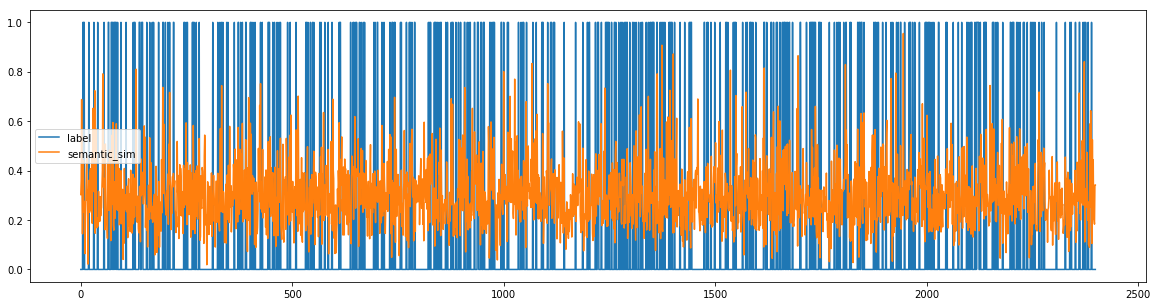

In [271]:

train_data[2002].plot(y=['label','semantic_sim'],figsize=(20, 5))

In [228]:
len(train_data[2002][(train_data[2002]['label']==0)])

2000

In [261]:
train_data[1993]['semantic_sim']=train_data[1993].apply(lambda row:
                                                        word_vectors.n_similarity(
                                                            gr.node_label_find(key_list,row[0][0]).lower().split(),
                                                        gr.node_label_find(key_list,row[0][1]).lower().split()) ,axis=1)


In [269]:
train_data[1993][(train_data[1993]['label']==0)]['semantic_sim'].mean()

0.28990412962407786

In [223]:
train_data[2002].mean()

label            0.166667
aut              0.527561
art              0.376327
closeness        0.505929
partition        0.044167
y_weight         0.326812
type             0.522222
partition_cnt    0.201744
path_len3        0.028500
e                0.252831
dtype: float64